<a href="https://colab.research.google.com/github/YanSym/Data-Science-Projects/blob/master/IMDB_Analise_Sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: Natural Language Processing
### Analise de sentimentos
### Disciplina: PCS5029

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=600 height=350/>

### Imports

In [3]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from google.colab import drive
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from collections import Counter
import random

#!pip install transformers
#!pip install ktrain

import ktrain
from ktrain import text
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

#import kerastuner as kt
#from kerastuner.tuners import BayesianOptimization
#nltk.download('stopwords');

### Métodos

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))


def print_results(true, pred):
  # accuracy
  accuracy = accuracy_score(true, pred)
  accuracy = round(accuracy, 4)
  print ('Accuracy:', accuracy)

  # f1 score
  f1_score = metrics.f1_score(true, pred)
  f1_score = round(f1_score, 4)
  print ('F1 Score:', f1_score)
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Dataset

In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

df_train = pd.DataFrame({'review':train_examples, 'sentiment':train_labels})
df_test = pd.DataFrame({'review':test_examples, 'sentiment':test_labels})

movie_reviews = pd.concat([df_train, df_test]).reset_index(drop=True)

movie_reviews['review'] = movie_reviews['review'].str.decode("utf-8")

print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.1, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


False
(50000, 2)
(5000, 2)


,review,sentiment
41986,I was expecting a lot from Mr.Amitabh Bachan's...,0
33935,"Well, it has to be said that Monster Man is a ...",1
46975,Even though I have great interest in Biblical ...,0
16402,The world is made up two different types of mo...,1
39790,Background info - The movies Octopussy & Never...,1


### Analises

1    2500
0    2500
Name: sentiment, dtype: int64


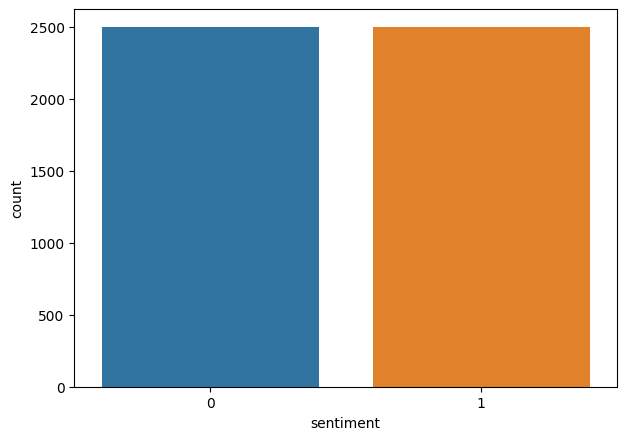

In [ ]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
print ('Max len:', movie_reviews['len'].max())
print ('Min len:', movie_reviews['len'].min())
print ('Mean len:', movie_reviews['len'].mean())

Max len: 12930
Min len: 111
Mean len: 1327.1528


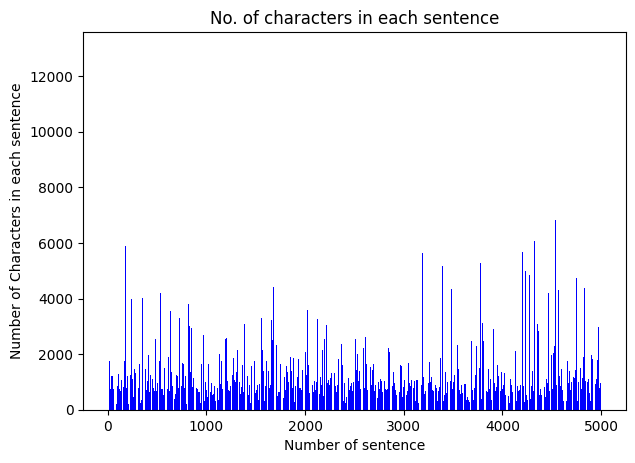

In [ ]:
sentences = [len(sent) for sent in movie_reviews['review']]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(sentences)+1), sentences, color = ['blue'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

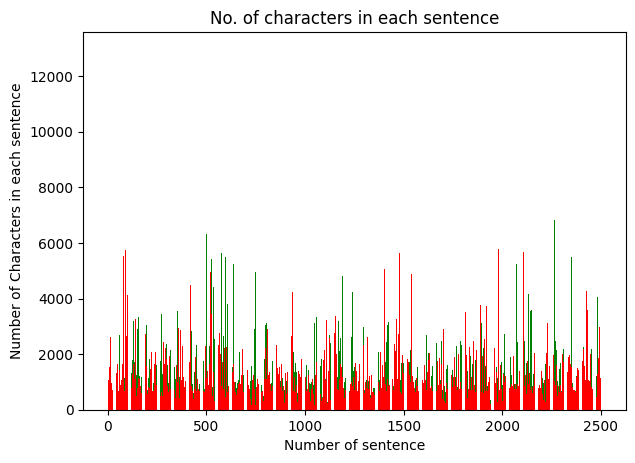

In [ ]:
df_positive = movie_reviews.query('sentiment == 1')
df_negative = movie_reviews.query('sentiment == 0')

positive_sentences = [len(sent) for sent in df_positive['review']]
negative_sentences = [len(sent) for sent in df_negative['review']]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(positive_sentences)+1), positive_sentences, color = ['green'])
plt.bar(range(1, len(negative_sentences)+1), negative_sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence',
              xlabel='Number of sentence',
              ylabel='Number of Characters in each sentence');

In [ ]:
movie_reviews['len'] = [len(sent) for sent in movie_reviews['review']]
movie_reviews_short = movie_reviews.query("len <= 200")
movie_reviews_lon = movie_reviews.query("len >= 3_000")

print(movie_reviews['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_short['sentiment'].value_counts(dropna=False, normalize=True))
print(movie_reviews_lon['sentiment'].value_counts(dropna=False, normalize=True))

1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.5
0    0.5
Name: sentiment, dtype: float64
1    0.552
0    0.448
Name: sentiment, dtype: float64


### Palavras mais frequentes nas críticas

In [ ]:
lista_strings = ' '.join(df_positive['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_positivos = [valor[0] for valor in counter_object.most_common(1000)]

lista_strings = ' '.join(df_negative['review'].tolist()).split(' ')
counter_object = Counter(lista_strings)
palavras_mais_aparecem_negativos = [valor[0] for valor in counter_object.most_common(1000)]

lista_positivos = list(set(palavras_mais_aparecem_positivos).difference(set(palavras_mais_aparecem_negativos)))
print ('Positivas:')
print (lista_positivos)

lista_negativos = list(set(palavras_mais_aparecem_negativos).difference(set(palavras_mais_aparecem_positivos)))
print ('Negativas:')
print (lista_negativos)

print ('Palavras positivas:')
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
print (list_positive_words)

print ('Palavras positivas:')
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']
print (list_negative_words)

Positivas:
['theme', 'French', 'sometimes', 'hilarious', 'Peter', 'emotions', 'forget', 'Their', 'pure', 'brings', 'too,', 'control', 'enjoyable', 'animated', 'believable', 'portrayed', 'level', 'lovely', 'whom', 'message', 'social', 'dark', 'roles', 'Japanese', 'you.', 'romantic', 'series.', 'Also,', 'drug', 'beautifully', 'cinematography', 'series,', 'begins', 'deserves', 'herself', 'Best', 'uses', 'compared', 'age', 'towards', 'country', 'caught', 'Bill', 'Oscar', 'moving', 'perfectly', 'decides', 'favorite', 'dramatic', "/>It's", 'reality', 'novel', 'episodes', "'The", 'superb', 'recently', 'easy', 'effective', 'murder', 'catch', 'life,', 'touching', 'dance', 'beauty', 'documentary', 'Jane', 'war', 'power', 'soundtrack', 'Paul', 'brilliant', 'emotional', 'people,', 'leads', 'War', 'parents', 'Sam', 'working', 'incredible', 'love,', 'funniest', 'Great', 'King', 'changes', 'heart', 'times,', 'today', 'Man', 'solid', 'watch.', 'elements', 'directors', 'unique', 'William', 'powerful', 

### Pre-processamento

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']

### Separa dados em treino e teste

In [ ]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Modelo Dummy

In [ ]:
list_positive_words = ['like', 'love', 'good', 'amazing', 'pure', 'lovely', 'best', 'enjoyable', 'talanted', 'fantastic', 'best', 'superb', 'incredible', 'happy']
list_negative_words = ['wasted', 'disappointed', 'horrible', 'fake', 'killing', 'awful', 'pathetic', 'screenplay', 'joke', 'ridiculous', 'boring', 'bad', 'silly']

def modelo_dummy(texto):
  texto = texto.split(' ')
  if any(x in list_positive_words for x in texto):
    return 1
  elif any(x in list_negative_words for x in texto):
    return 0
  else:
    return random.randint(0, 1)

df_train = pd.DataFrame(X_train, columns=['review'])
df_test = pd.DataFrame(X_test, columns=['review'])

df_train['prediction_dummy'] = df_train['review'].apply(modelo_dummy)
df_test['prediction_dummy'] = df_test['review'].apply(modelo_dummy)

score_train = round(accuracy_score(df_train['prediction_dummy'], y_train), 4)
score_test = round(accuracy_score(df_test['prediction_dummy'], y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, df_test['prediction_dummy'])

Train Accuracy: 0.5412
Test Accuracy: 0.522
Accuracy: 0.522
F1 Score: 0.647


### Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=200/>

In [ ]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [ ]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9988
Test Accuracy: 0.799
Accuracy: 0.799
F1 Score: 0.7972


### Score test

In [ ]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

0.9393853698669685
0.09259102304322094


,text,score,rating
0,"The movie was amazing, I loved it, very good",0.939385,Positivo
1,"I hate this movie, it is very bad and terrible",0.092591,Negativo


### BoW (Bag of Words) + Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.8908
Test Accuracy: 0.688
Accuracy: 0.688
F1 Score: 0.6797


### BoW (Bag of Words) + Random Forest

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.8362
Test Accuracy: 0.772
Accuracy: 0.772
F1 Score: 0.7795


## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=200/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=290/>

In [ ]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [ ]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.9988
Test Accuracy: 0.799
Accuracy: 0.799
F1 Score: 0.7972


### Tf-Idf (Bag of Words) + Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.8908
Test Accuracy: 0.688
Accuracy: 0.688
F1 Score: 0.6797


### Tf-Idf (Bag of Words) + Decision Tree

In [ ]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.6738
Test Accuracy: 0.633
Accuracy: 0.633
F1 Score: 0.6994


### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [ ]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.788
Test Accuracy: 0.766
Accuracy: 0.766
F1 Score: 0.7817


### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.844
Test Accuracy: 0.784
Accuracy: 0.784
F1 Score: 0.7923


### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [ ]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.865
Test Accuracy: 0.786
Accuracy: 0.786
F1 Score: 0.7985


### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [ ]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(df_test_str))

Train Accuracy: 0.957
Test Accuracy: 0.797
Accuracy: 0.797
F1 Score: 0.7992


## Modelos com Embedding

### Regressão Logística

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.5638
Test Accuracy: 0.53
Accuracy: 0.53
F1 Score: 0.5446


### Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.563
Test Accuracy: 0.523
Accuracy: 0.523
F1 Score: 0.4832


### Árvore de Decisão

In [ ]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.5868
Test Accuracy: 0.514
Accuracy: 0.514
F1 Score: 0.3639


### Random Forest

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)
print_results(y_test, classifier.predict(X_test))

Train Accuracy: 0.8238
Test Accuracy: 0.539
Accuracy: 0.539
F1 Score: 0.4973


### Modelo simples com Redes Neurais v1 (sem Early Stopping)

In [ ]:
def predict_class(lista):
  lista_return = []
  for element in lista:
    lista_return.append(int(element>=0.5))
  return lista_return

Epoch 1/50
25/25 [==============================] - 1s 14ms/step - loss: 244.1686 - acc: 0.4866 - val_loss: 102.9637 - val_acc: 0.4963
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 120.0587 - acc: 0.5159 - val_loss: 29.9671 - val_acc: 0.5050
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 67.9921 - acc: 0.4884 - val_loss: 7.7782 - val_acc: 0.5038
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 36.5233 - acc: 0.4944 - val_loss: 2.1602 - val_acc: 0.5025
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 21.4476 - acc: 0.4950 - val_loss: 1.0922 - val_acc: 0.5025
Epoch 6/50
25/25 [==============================] - 0s 5ms/step - loss: 15.6768 - acc: 0.4981 - val_loss: 0.8826 - val_acc: 0.5038
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 10.8843 - acc: 0.4969 - val_loss: 0.7770 - val_acc: 0.5038
Epoch 8/50
25/25 [==============================] - 0s 5ms/step - loss: 8.736

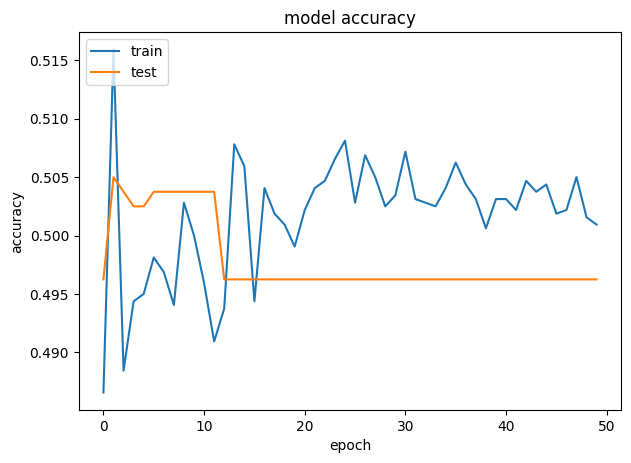

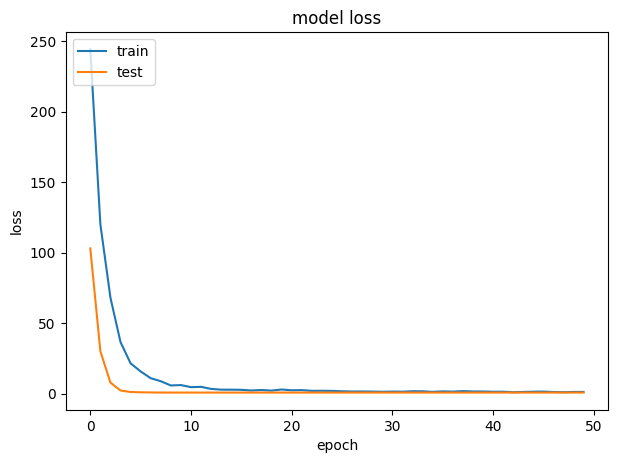

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

Epoch 1/30
32/32 [==============================] - 1s 10ms/step - loss: 64.2051 - acc: 0.5040 - val_loss: 8.2619 - val_acc: 0.4913

Epoch 00001: val_loss improved from inf to 8.26190, saving model to best_model.h5
Epoch 2/30
32/32 [==============================] - 0s 5ms/step - loss: 2.2463 - acc: 0.5038 - val_loss: 2.3432 - val_acc: 0.4825

Epoch 00002: val_loss improved from 8.26190 to 2.34316, saving model to best_model.h5
Epoch 3/30
32/32 [==============================] - 0s 5ms/step - loss: 1.0864 - acc: 0.5015 - val_loss: 1.6848 - val_acc: 0.4837

Epoch 00003: val_loss improved from 2.34316 to 1.68479, saving model to best_model.h5
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.8399 - acc: 0.5025 - val_loss: 1.5173 - val_acc: 0.4837

Epoch 00004: val_loss improved from 1.68479 to 1.51728, saving model to best_model.h5
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.7472 - acc: 0.5040 - val_loss: 1.4044 - val_acc: 0.4837

Epo

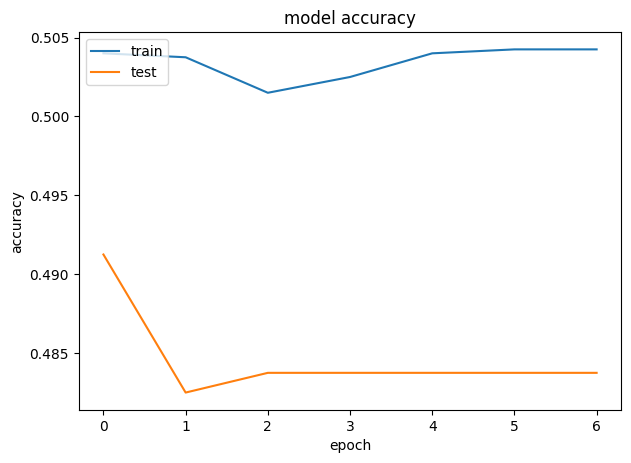

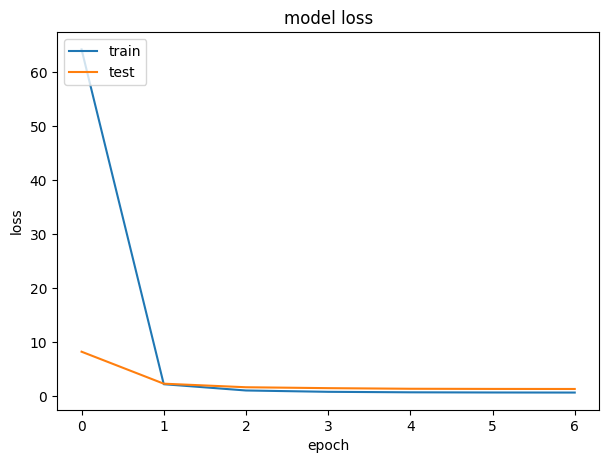

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Simple Model Embedding layer (sem Glove)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          3516900   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 3,526,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 16ms/step - loss: 0.6917 - acc: 0.5213 - val_loss: 0.6849 - val_acc: 0.5650

Epoch 00001: val_loss improved from inf to 0.68488, saving model to best_model.h5
Epoch 2/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6345 - acc: 0.9053 - val_loss: 0.6705 - val_acc: 0.6662

Epoch 00002: val_loss 

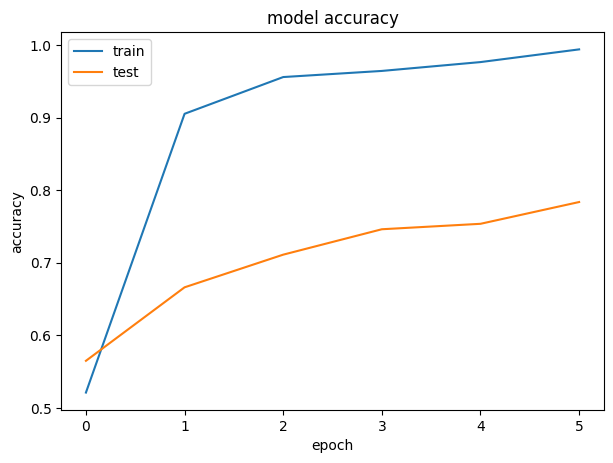

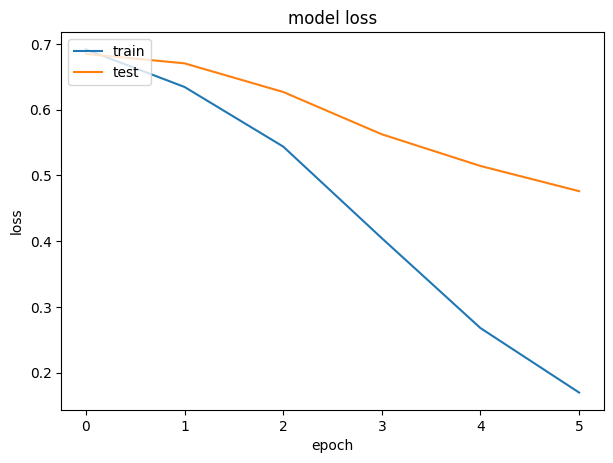

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Glove

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/20
25/25 [==============================] - 1s 10ms/step - loss: 0.7024 - acc: 0.5634 - val_loss: 0.6893 - val_acc: 0.5913
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5513 - acc: 0.7281 - val_loss: 0.6577 - val_acc: 0.6300
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4689 - acc: 0.7944 - val_los

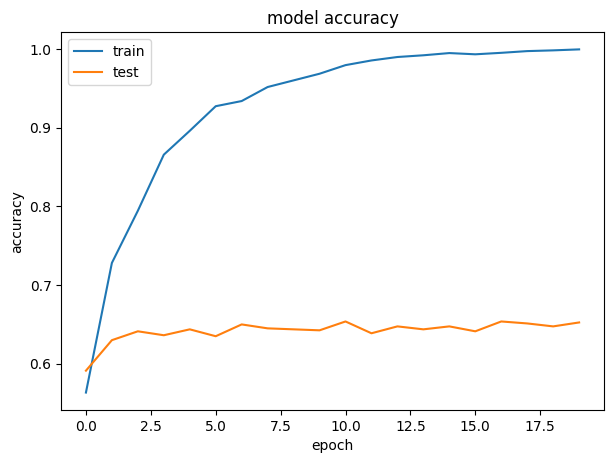

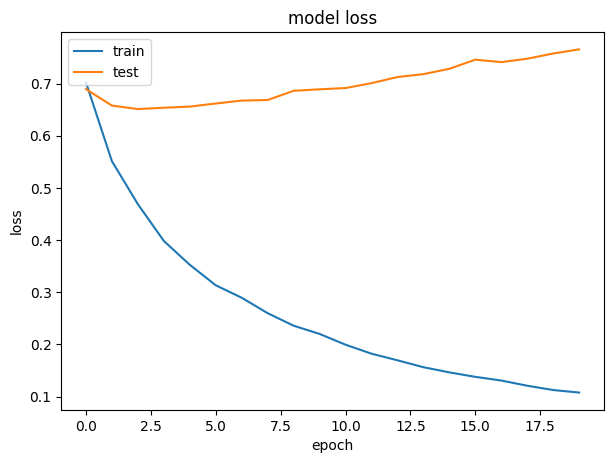

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Simple Model Glove (com Early Stopping)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 10001     
Total params: 3,526,901
Trainable params: 10,001
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 1s 12ms/step - loss: 0.6975 - acc: 0.5612 - val_loss: 0.6766 - val_acc: 0.6112

Epoch 00001: val_loss improved from inf to 0.67662, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 4ms/step - loss: 0.5333 - acc: 0.7441 - val_loss: 0.6502 - val_acc: 0.6212

Epoch 00002: val_l

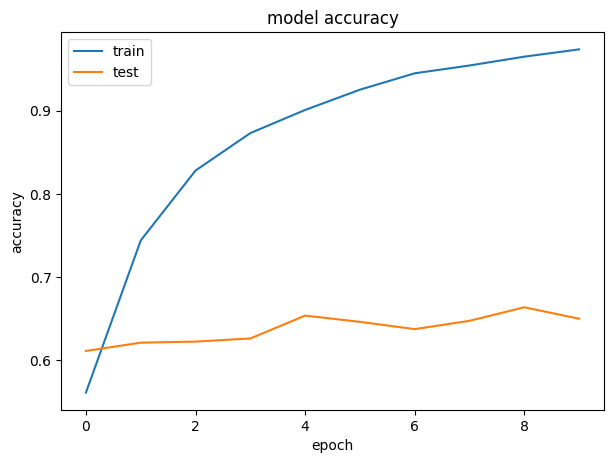

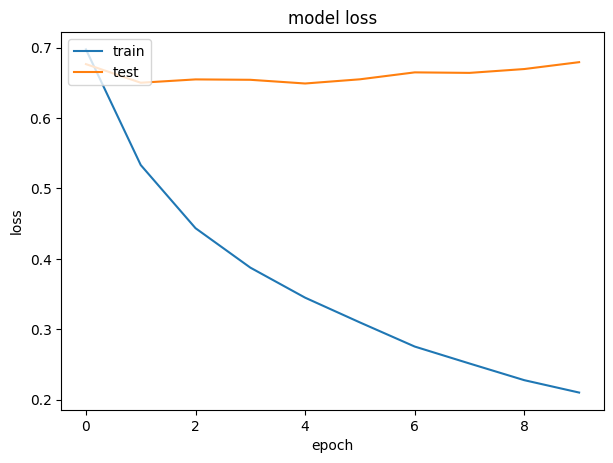

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### CNN

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 129       
Total params: 3,581,157
Trainable params: 64,257
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/50
25/25 [==============================] - 1s 18ms/step - loss: 0.6615 - acc: 0.6075 - val_loss: 0.6231 - val_acc: 0.6700
Epoch 2/50
25/25 [==============================] - 0s 11ms/step - loss: 0.5321 - acc: 0.7669 - val_

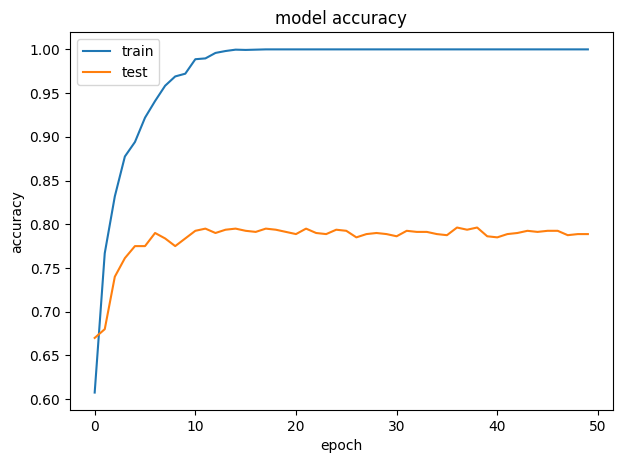

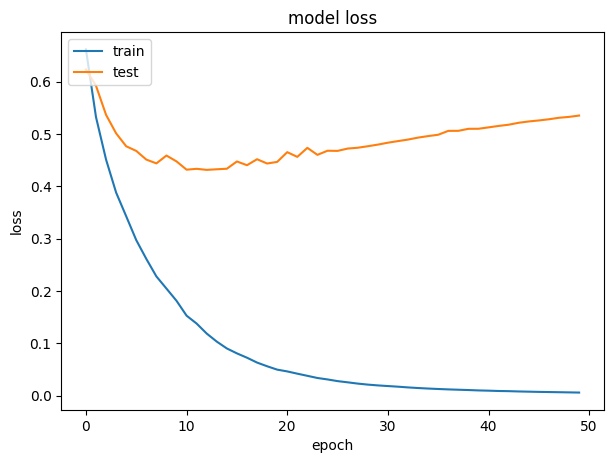

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### CNN Early Stopping

Epoch 1/30
25/25 [==============================] - 1s 34ms/step - loss: 0.7908 - acc: 0.5353 - val_loss: 0.6515 - val_acc: 0.6075

Epoch 00001: val_loss improved from inf to 0.65150, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5738 - acc: 0.7328 - val_loss: 0.6063 - val_acc: 0.6650

Epoch 00002: val_loss improved from 0.65150 to 0.60630, saving model to best_model.h5
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.5023 - acc: 0.8025 - val_loss: 0.5599 - val_acc: 0.7250

Epoch 00003: val_loss improved from 0.60630 to 0.55992, saving model to best_model.h5
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.4417 - acc: 0.8469 - val_loss: 0.5272 - val_acc: 0.7475

Epoch 00004: val_loss improved from 0.55992 to 0.52722, saving model to best_model.h5
Epoch 5/30
25/25 [==============================] - 0s 11ms/step - loss: 0.3927 - acc: 0.8731 - val_loss: 0.5022 - val_acc: 0.7650

Ep

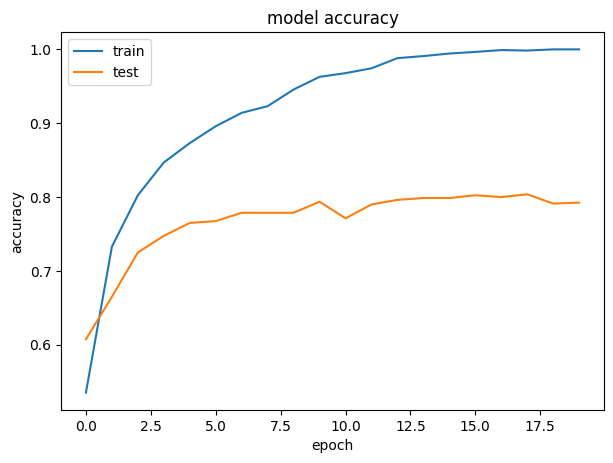

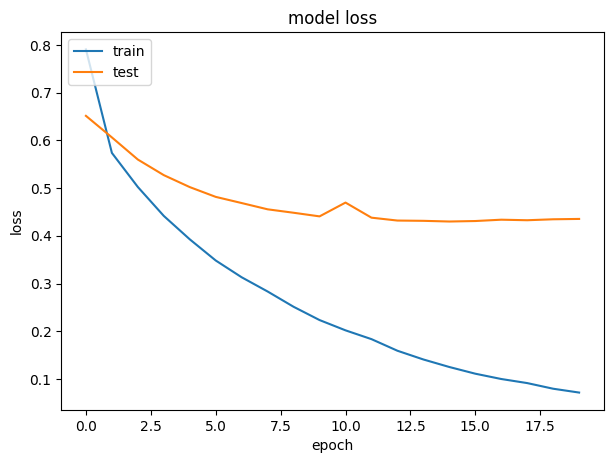

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### RNN

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 3,546,341
Trainable params: 29,441
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/30
25/25 [==============================] - 5s 137ms/step - loss: 0.7269 - acc: 0.5166 - val_loss: 0.7014 - val_acc: 0.5587

Epoch 00001: val_loss improved from inf to 0.70138, saving model to best_model.h5
Epoch 2/30
25/25 [==============================] - 3s 120ms/step - loss: 0.6788 - acc: 0.5784 - val_loss: 0.6960 - val_acc: 0.5738

Epoch 00002: va

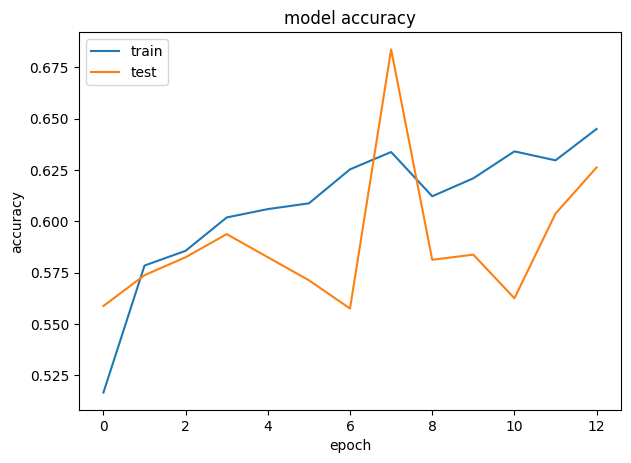

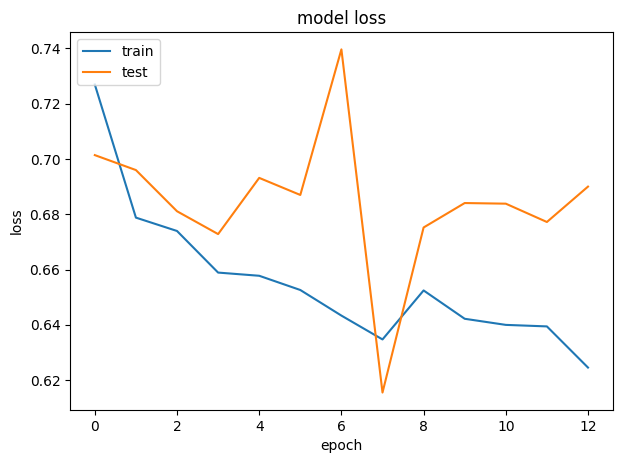

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### LSTM

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/15
25/25 [==============================] - 9s 277ms/step - loss: 0.6774 - acc: 0.5631 - val_loss: 0.6704 - val_acc: 0.6137
Epoch 2/15
25/25 [==============================] - 6s 248ms/step - loss: 0.6399 - acc: 0.6306 - val_loss: 0.7566 - val_acc: 0.5412
Epoch 3/15
25/25 [==============================] - 6s 247ms/step - loss: 0.6055 - acc: 0.6816 - v

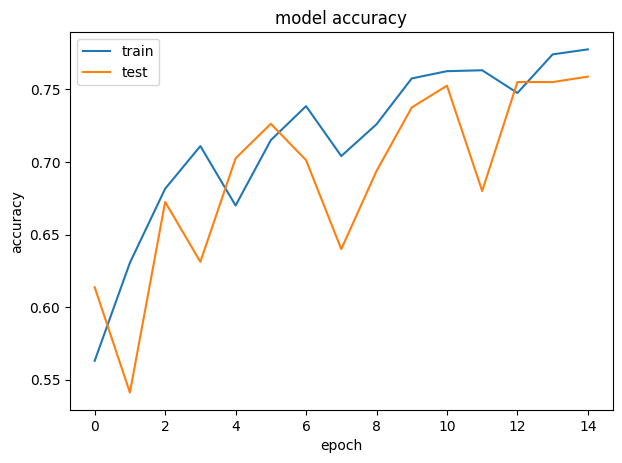

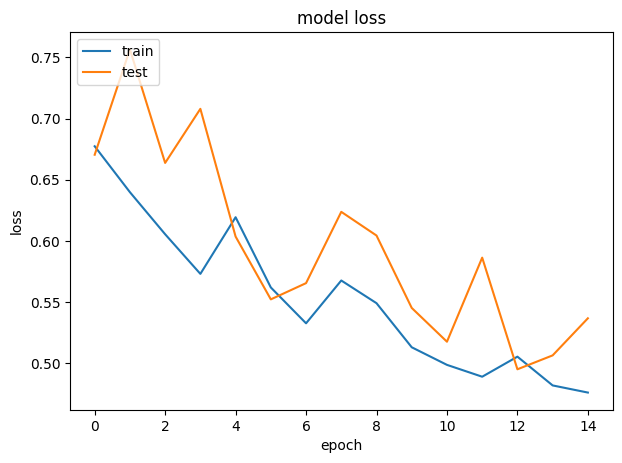

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### LSTM com Early Stopping

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 100)          3516900   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 129       
Total params: 3,634,277
Trainable params: 117,377
Non-trainable params: 3,516,900
_________________________________________________________________
None
Epoch 1/100
25/25 [==============================] - 9s 282ms/step - loss: 0.6686 - acc: 0.5713 - val_loss: 0.6556 - val_acc: 0.6488

Epoch 00001: val_loss improved from inf to 0.65561, saving model to best_model.h5
Epoch 2/100
25/25 [==============================] - 6s 259ms/step - loss: 0.6265 - acc: 0.6550 - val_loss: 0.6066 - val_acc: 0.6938

Epoch 00002:

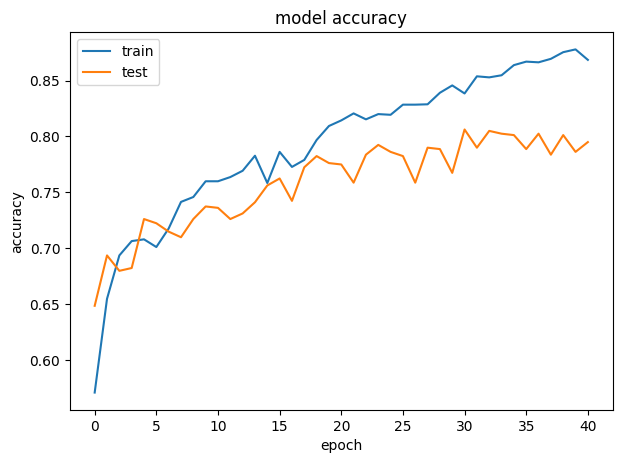

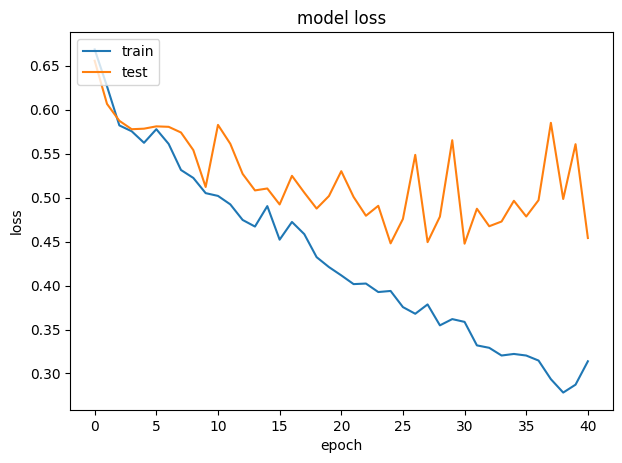

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)

# load a saved model (best model)
model = load_model('best_model.h5')
print(model.summary())

score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
print_results(y_test, predict_class(model.predict(X_test)))
plot_results(history)

### Prediction (sample)

In [ ]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

['mostly uninvolving biblical mumbo jumbo that drags on for well over two hours the only thing that saves this film from god wreath and there is only one god remember is the unintentionally funny dialog and good battle scene which comes far too late in the movie for most of the two hours until the action scenes there is too much talking the dialog is so inept that the movie just begs to be spoofed by mst george sanders is absolutely awful one of the most animated overly theatrical performances ve ever seen brynner isn much better his stiff wooden acting combined with the horrendous fortune cookie wisdom utterings make for rather boring and silly solomon it seems that every time brynner opens his mouth something oh so wise and ridiculously high and mighty comes out to an extent it not sanders and brynner fault because of the crappy comical dialog and the typically biblical one dimensional characterization but they made little effort otherwise brynner accent even reminds bit of schwarzen

### Prediction (tests)

In [ ]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'The movie was good, but I hated it',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

,text,score,rating
0,"The movie was amazing, I loved it, very good",0.991725,Positivo
1,"The movie was good, but I hated it",0.300432,Negativo
2,"I hate this movie, it is very bad and terrible",0.033941,Negativo


Modelo TensorFlow Hub

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_16 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 5s 126ms/step - loss: 0.6694 - accuracy: 0.5249 - val_loss: 0.6196 - val_accuracy: 0.5789
Epoch 2/10
30/30 [==============================] - 4s 118ms/step - loss: 0.5560 - accuracy: 0.6675 - val_loss: 0.5180 - val_accuracy: 0.7253
Epoch 3/10
30/30 [==============================] - 5s 120ms/step - loss: 0.4282 - accu

Modelo Bert

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz',
                                  origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                  extract = True)

IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir = IMDB_DATADIR,
                                                                       classes = ['pos', 'neg'],
                                                                       maxlen = 200,
                                                                       train_test_names = ['train', 'test'],
                                                                       preprocess_mode = 'bert')

model = text.text_classifier(name = 'bert',
                             train_data = (x_train, y_train),
                             preproc = preproc)

learner = ktrain.get_learner(model = model,
                             train_data = (x_train, y_train),
                             val_data = (x_test, y_test),
                             batch_size = 6)

learner.fit_onecycle(lr = 2e-5,
                     epochs = 1)

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 200
done.


begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 3306s 787ms/step - loss: 0.2959 - accuracy: 0.8736 - val_loss: 0.2191 - val_accuracy: 0.9107
